In [1]:
import scipy.stats as sista
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mat73 as mt

import pandas as pd
import seaborn as sns
import pingouin as pg

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
alpha = mt.loadmat('grand_power_filteredBands_alltrials.mat')
data = alpha['gpow']['posterior']
nSubs = np.size(data,0)
nConds = np.size(data,1)

#trial timing
t0 = -400
te = 1551
samples = np.arange(t0,te,2)

In [14]:
# significance testing averaged across the delay period
mean_delay_alpha = pd.DataFrame(data[..., samples>650].mean(2), columns=['2S', '2D', '4S', '4D'])
mean_delay_alpha['PID'] = np.arange(1, data.shape[0]+1)
mean_delay_alpha = mean_delay_alpha.melt(id_vars='PID', value_name='Posterior Alpha Power')
mean_delay_alpha['SetSize'] = mean_delay_alpha['variable'].astype(str).str[0]
mean_delay_alpha['location'] = mean_delay_alpha['variable'].astype(str).str[1]
mean_delay_alpha.to_csv('exp1A_alpha_SetSizeLoc_ANOVA.csv')
pg.rm_anova(data=mean_delay_alpha, dv='Posterior Alpha Power', within=['SetSize', 'location'], subject='PID', effsize='ng2')



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,SetSize,0.789007,1,9,0.789007,8.064019,0.019412,0.019412,0.002717,1.0
1,location,1.575269,1,9,1.575269,10.602523,0.009899,0.009899,0.005410,1.0
2,SetSize * location,0.000789,1,9,0.000789,0.057906,0.815229,0.815229,0.000003,1.0


In [5]:
0.000003

3e-06

In [6]:
# mean_delay_alpha[mean_delay_alpha.variable.isin(['2D', '4S'])]
pg.ttest(x=mean_delay_alpha.loc[mean_delay_alpha.variable=='2D', 'Posterior Alpha Power'].values, y=mean_delay_alpha.loc[mean_delay_alpha.variable=='4S', 'Posterior Alpha Power'].values, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.567128,9,two-sided,0.151528,"[-0.28, 0.05]",0.041351,0.787,0.051582


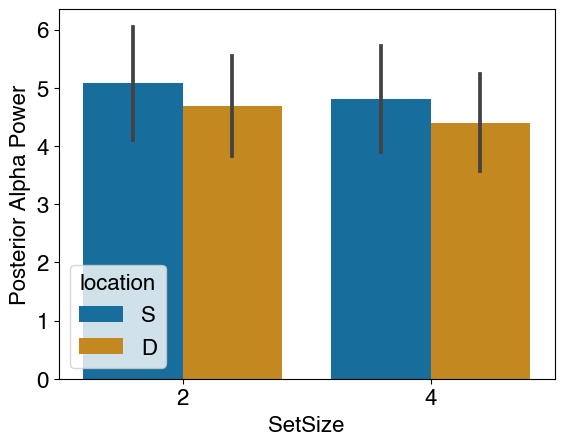

In [7]:
_ = sns.barplot(data = mean_delay_alpha, x='SetSize', y='Posterior Alpha Power', hue='location', errorbar='se', palette='colorblind')

In [8]:
conds = 'grand_power_filteredBands_alltrials'
theseLabels = ['2 Same','2 Diff','4 Same','4 Diff']


t = samples

bpts = np.isin(t,np.arange(-400,1))
pcentdata = np.zeros((data.shape))
pcentdata_mean = np.zeros((np.size(data,1),np.size(data,2)))
pcentdata_err = np.zeros((np.size(data,1),np.size(data,2)))
for cond in np.arange(nConds):
    temp = data[:,cond,:]
    newtemp = np.zeros((np.size(temp,0),np.size(temp,1)))
    bdata = np.mean(temp[:,bpts],1)

    for tt in np.arange(np.size(temp,0)):
        newtemp[tt,:] = np.divide((temp[tt,:] - bdata[tt]),bdata[tt])*100
        
    pcentdata[:,cond,:] = newtemp
    pcentdata_mean[cond,:] = np.mean(newtemp,0)
    pcentdata_err[cond,:] = np.divide(np.std(newtemp,0),np.sqrt(nSubs))
    

In [9]:
# significance testing averaged across the delay period
mean_delay_alpha_pcent = pd.DataFrame(pcentdata[..., (samples>650) & (samples < 1450)].mean(2), columns=['2S', '2D', '4S', '4D'])
mean_delay_alpha_pcent['PID'] = np.arange(1, data.shape[0]+1)
mean_delay_alpha_pcent = mean_delay_alpha_pcent.melt(id_vars='PID', value_name='Percent Change in Alpha Power over the Delay Period')
mean_delay_alpha_pcent['SetSize'] = mean_delay_alpha_pcent['variable'].astype(str).str[0]
mean_delay_alpha_pcent['location'] = mean_delay_alpha_pcent['variable'].astype(str).str[1]
pg.rm_anova(data=mean_delay_alpha_pcent, dv='Percent Change in Alpha Power over the Delay Period', within=['SetSize', 'location'], subject='PID', effsize='ng2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,SetSize,402.798391,1,9,402.798391,28.144078,0.000491,0.000491,0.018646,1.0
1,location,236.874961,1,9,236.874961,4.801398,0.056139,0.056139,0.011050,1.0
2,SetSize * location,32.851983,1,9,32.851983,4.516150,0.062515,0.062515,0.001547,1.0


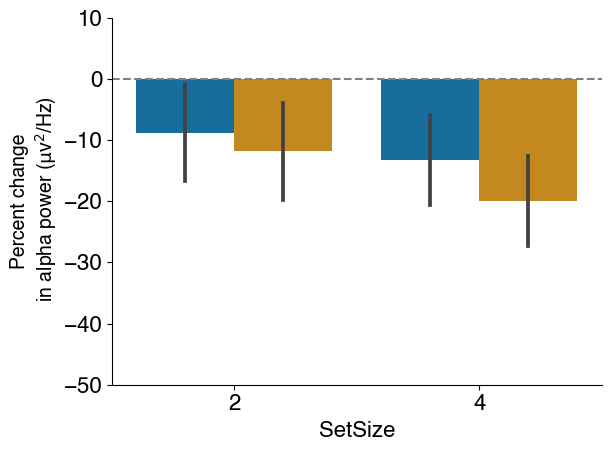

In [10]:
ax = sns.barplot(data = mean_delay_alpha_pcent, x='SetSize', y='Percent Change in Alpha Power over the Delay Period', errorbar='se', hue='location', palette='colorblind')
# remove left and upper spines from plot
sns.despine()
# add gray line at 0
ax.axhline(0, ls='--', color='gray')
plt.ylim([-50, 10])
plt.ylabel('Percent change\n in alpha power (\u03BCv$^2$/Hz)', fontsize=14)
plt.tight_layout()
# remove legend
ax.get_legend().remove()
plt.savefig('figure_posterior_alpha_change_barplot.svg',bbox_inches='tight',dpi = 1000,format='svg')


In [11]:
#calculate accuracy
#average across folds
acc_mean1 = pcentdata_mean[0,:] # 2S
acc_mean2 = pcentdata_mean[1,:] # 2D
acc_mean3 = pcentdata_mean[2,:] # 4S
acc_mean4 = pcentdata_mean[3,:] # 4D

se1 = pcentdata_err[0,:]
se2 = pcentdata_err[1,:]
se3 = pcentdata_err[2,:]
se4 = pcentdata_err[3,:]
upper_bound1, lower_bound1 = acc_mean1 + se1, acc_mean1 - se1
upper_bound2, lower_bound2 = acc_mean2 + se2, acc_mean2 - se2
upper_bound3, lower_bound3 = acc_mean3 + se3, acc_mean3 - se3
upper_bound4, lower_bound4 = acc_mean4 + se4, acc_mean4 - se4


In [12]:
#chance performance based on number of conditions
chance = 0
#sig_y = chance+(chance*.25)
chance_text_y = 0

ylim = [-50,10]

stim_lower = ylim[0]
stim_upper = ylim[1]

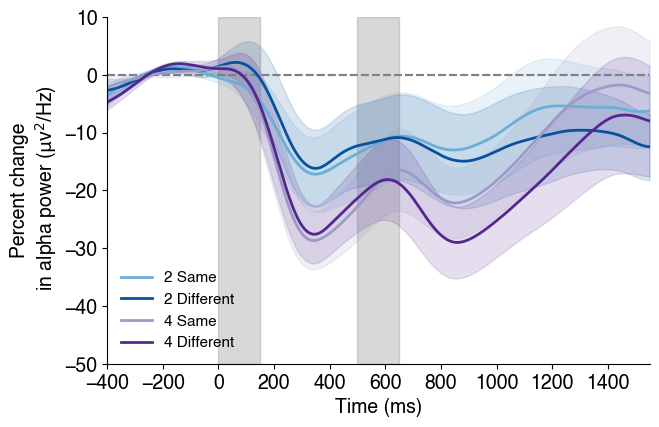

In [13]:
matplotlib.rcParams['figure.figsize'] = [7, 4.5]
ax = plt.subplot(111)

stim_time1 = [0,151]
stim_time2 = [500,651]

# ss2same, ss2diff, ss4same, ss4diff
color1 = np.divide([107,174,214],255)
color2 = np.divide([8,81,156],255)
color3 = np.divide([158,154,200],255)
color4 = np.divide([84,39,143],255)

# stim timing shading
ax.fill_between(stim_time1,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.3)
ax.plot(t,np.ones((len(t)))*chance,'--',color='gray')
ax.fill_between(stim_time2,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.3)
ax.plot(t,np.ones((len(t)))*chance,'--',color='gray')

ax.fill_between(t,upper_bound1,lower_bound1, alpha=.15,color=color1)
ax.plot(t,acc_mean1,color=color1,linewidth=2,label = '2 Same')

ax.fill_between(t,upper_bound2,lower_bound2, alpha=.15,color=color2)
ax.plot(t,acc_mean2,color=color2,linewidth=2,label = '2 Different')

ax.fill_between(t,upper_bound3,lower_bound3, alpha=.15,color=color3)
ax.plot(t,acc_mean3,color=color3,linewidth=2,label = '4 Same')

ax.fill_between(t,upper_bound4,lower_bound4, alpha=.15,color=color4)
ax.plot(t,acc_mean4,color=color4,linewidth=2,label = '4 Different')



# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks(np.arange(.1,1.1,.1))
ax.set_xticks(np.arange(-400,1551,200))
#ax.set_xticklabels(x) 
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlim(-400,1551)
plt.ylim(ylim)

plt.legend(loc='lower left',frameon=False,fontsize=11)

# labelling
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Percent change\n in alpha power (\u03BCv$^2$/Hz)', fontsize=14)

plt.savefig('figure_posterior_alpha_change.svg',bbox_inches='tight',dpi = 1000,format='svg')
plt.show()
